# Historico de Bitácoras Onomásticas del SEMEFO-DF
# Análisis de diagnósticos

Las [Historico de Bitácoras Onomásticas del Servicio Médico Forense del Distrito Federal (SEMEFO-DF)](https://datamx.io/dataset/ingresos-del-semefo-df-1965-1982-inai), han sido sistematizada por la Comisión Nacional de Búsqueda (CNB). Este conjunto de datos se obtuvo a través de una solicitud de acceso a la información disponible en el Portal de Transparencia del Instituto Nacional de acceso a la Información (INAI) en noviembre de 2023 y existe una copia en el portal ciudadano _datamx_ de Codeando México.

El **SEMEFO-DF (Servicio Médico Forense Distrito Federal)** ahora [INCIFO-CdMx](https://www.incifocdmx.gob.mx/) es una institución oficial encargada de realizar autopsias y estudios forenses para esclarecer las causas de muerte, principalmente en casos de muertes violentas, sospechosas o relacionadas con hechos delictivos. Las **Bitácoras Onomásticas (BO)** son registros administrativos históricos utilizados por el SEMEFO para documentar el ingreso de cadáveres o restos humanos a sus instalaciones. Estas bitácoras contienen información detallada sobre cada ingreso, como el nombre de la persona fallecida, su edad, sexo, fecha de ingreso, institución de procedencia y diagnóstico preliminar de causa de muerte. En muchos casos, estos registros incluyen datos clave para identificar patrones históricos de mortalidad, enfermedades comunes y factores de riesgo, lo que las convierte en una fuente valiosa para estudios demográficos, epidemiológicos y de salud pública.

Podemos acceder a esta información con la [Plataforma de Transparencia](https://www.plataformadetransparencia.org.mx/Inicio) o en [datamx](https://datamx.io/dataset/ingresos-del-semefo-df-1965-1982-inai).

In [1]:
from joblib import load
import pandas as pd
from pandas.api.types import CategoricalDtype

from numpy import nan
from helper_pandas import *
from helper_networkx import *
from unidecode import unidecode
from scipy.stats import chi2_contingency

import networkx as nx
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

in_file = "data_clean/HBO_clean.pkl"
with open(in_file, 'rb') as f:
     df = load(f)

#Quitar filas vacias
df = df[df['Identificacion']!='S-D']
df.tail()

,Numero_progresivo_transcrito,Nombre_completo_transcrito,Primer_apellido,Segundo_apellido,Nombres_propios,Fecha_transcrito,Fecha_estandar,Fecha_año,Fecha_mes,Fecha_semana,...,Procedencia_transcrito,Procedencia_estandar,Procedencia_extendido,Procedencia_alcaldia,Procedencia_clasificacion,Numero_acta_transcrito,Expediente_SEMEFO_transcrito,Bitacora_ingresos,Foja_transcrito,Observaciones
ID,,,,,,,,,,,,,,,,,,,,,
BO_1982_07489,S-D,placenta,NaN,NaN,NaN,1982-06-05,1982-06-05,1982.0,6.0,22,...,15a,GAM-2,Coord Territorial 2 Gustavo A Madero (Col Arag...,Gustavo A Madero,Judicial,960,3079,semefo_df_bo_1982,156,NaN
BO_1982_07490,S-D,5 dedos del pie derecho de desconocido,NaN,NaN,NaN,1982-06-05,1982-06-05,1982.0,6.0,22,...,32a,COY-2,Coord Territorial 2 Coyoacan (Col Romero de Te...,Coyoacan,Judicial,950,3060,semefo_df_bo_1982,156,NaN
BO_1982_07491,S-D,dedo de desconocido,NaN,NaN,NaN,1982-11-19,1982-11-19,1982.0,11.0,46,...,32a,COY-2,Coord Territorial 2 Coyoacan (Col Romero de Te...,Coyoacan,Judicial,2005,6389,semefo_df_bo_1982,156,NaN
BO_1982_07492,S-D,4 dedos de desconocido,NaN,NaN,NaN,1982-11-28,1982-11-28,1982.0,11.0,47,...,27a,XO-2,Coord Territorial 2 Xochimilco (Barrio de San ...,Xochimilco,Judicial,959,6528,semefo_df_bo_1982,156,NaN
BO_1982_07493,S-D,osamenta de desconocido,NaN,NaN,NaN,1982-10-11,1982-10-11,1982.0,10.0,41,...,9a,MH-1,Coord Territorial 1 Miguel Hidalgo – Hospital ...,Miguel Hidalgo,Hospital,4193,5629,semefo_df_bo_1982,156,no se recibio necropsia. es una osamenta.


In [2]:
from matplotlib.colors import LinearSegmentedColormap

dic_color = {'Poblacion':'#0504aa', 'S-D':'#999999', 'S-D (DF)':'#d9d9d9', 'Masculino':'#377eb8', 'Masculino (DF)':'#80b1d3', 
             'Femenino':'#984ea3', 'Femenino (DF)':'#bebada', 
             'Conocido':'#4daf4a', 'Desconocido':'#dbb40c', 
             'Cadáver conocido':'#04d8b2', 'Cadáver desconocido':'#fdff52', 
             'Recién nacido':'#c875c4', 
             'Feto':'#ff7f00', 
             'Miembros':'#f781bf', 
             'Restos óseos':'#c85a53', }

gray_to_green = LinearSegmentedColormap.from_list('gray_to_green', ['#d9d9d9', '#2a7e19'])


Se llevó a cabo la siguiente selección para el análisis de los diagnósticos:
* Filtrado de restos óseos y sexo sin datos, por ser de baja frecuencia
* Clasificación con mínimo 5 ocurrencias

In [3]:
thr_col, thr_freq = 'Diagnostico_clasificacion', 5
df_diag = df.copy()

# Filtrar baja frecuencia tipo y sexo
df_diag = df_diag[ df_diag['Tipo_restos']!='Restos óseos' ]
df_diag['Tipo_restos'] = df_diag['Tipo_restos'].cat.remove_unused_categories()
df_diag = df_diag[ df_diag['Sexo'].isin(['Femenino','Masculino']) ]
df_diag['Sexo'] = df_diag['Sexo'].cat.remove_unused_categories()

# Filtrar diagnósticos con baja frecuecia
top_diag = df[thr_col].value_counts()
top_diag = top_diag[top_diag>=thr_freq].index.to_list()
df_diag = df_diag[ df_diag[thr_col].isin(top_diag) ]
df_diag[thr_col] = df_diag[thr_col].astype( CategoricalDtype(categories=top_diag, ordered=True) )
# Categorias
df_diag['Diagnostico_estandar'] = df_diag['Diagnostico_estandar'].cat.remove_unused_categories()
# Resultados operacion
print(f"Diagnosticos seleccionados: {df_diag.shape[0]}/{df['Diagnostico_estandar'].notna().sum()}\n")

Diagnosticos seleccionados: 39814/40943



## Diagnósticos por clasificación


Principales diagnósticos por clasificación

In [4]:
data = df_diag.groupby('Diagnostico_clasificacion').agg(
            freq=('Diagnostico_estandar', 'size'), 
            top=('Diagnostico_estandar', top_values_of_series_to_string),
            )
data = data.sort_values('freq', ascending=False).reset_index()
data.insert(2, 'prop', data['freq']/data['freq'].sum()*100)
#data = data.set_index('Diagnostico_clasificacion')
data = collapse_low_frequency(data, 7)
data

,Diagnostico_clasificacion,freq,prop,top
0,Traumatismos,20120.0,50.534988,"TM (7524), TCE (5988), TCT (1185), BN+TCE (635..."
1,Causas externas,4396.0,11.041342,"Quem (816), AOVA (809), AXA (564), ASB (540), ..."
2,Herida arma de fuego,3362.0,8.444266,"HPAF (1001), HPAFC (943), HPAFPT (601), HPAFA ..."
3,Respiratorio,2382.0,5.982820,"BN (1854), PN (234), N (129), EP (46), BBNT (45)"
4,Digestivo,1617.0,4.061385,"BN+CH (800), CH+PN (186), CH (158), BN+ENT (14..."
5,"Sintomas, signos y hallazgos anormales",1438.0,3.611795,"CVG (1329), BN+CVG (21), AN (5), CVG+PN (4), C..."
6,Afecciones periodo perinatal,1110.0,2.787964,"ANEN (563), EXPSM (498), FCPN (27), Anencefali..."
Otros,Otros,5389.0,13.535440,Otros


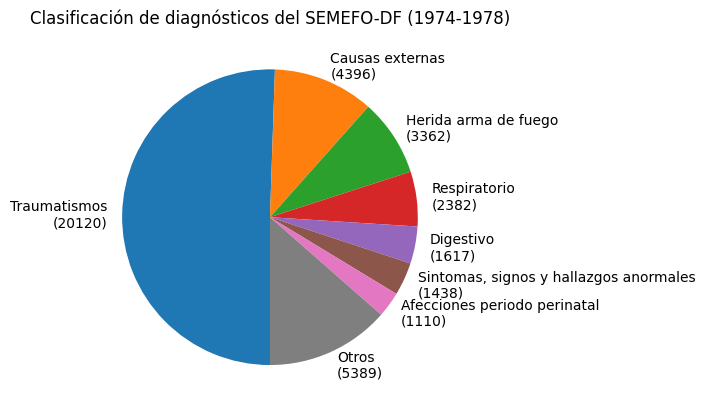

In [5]:
data['label'] = data['Diagnostico_clasificacion'] + data['freq'].apply(lambda i: f"\n({int(i)})")
data.set_index('label')['freq'] \
    .plot.pie(startangle=-90, counterclock=False, label='', title='Clasificación de diagnósticos del SEMEFO-DF (1974-1978)')
#plt.savefig('imagenes/BO_Diagnostico_Clasificacion.svg')
plt.show()

## Diagnósticos estandar

In [6]:
df_cat = pd.read_excel('catalogos/cat_diag_sustitucion.xlsx')
df_cat = df_cat.groupby('Diagnostico_estandar').agg(
                        {'Diagnostico_extendido':'first',
                         'freq':'sum',
                         'Npartes':'first', 'Nfalta':'first'}) \
               .sort_values('freq', ascending=False)
df_cat = df_cat.drop('S-D')
df_cat.insert(2, 'prop', df_cat['freq']/df_cat['freq'].sum()*100)
display(df_cat.shape)
collapse_low_frequency(df_cat, 15)


(2243, 5)

,Diagnostico_extendido,freq,prop,Npartes,Nfalta
TM,traumatismo multiple,7525.0,18.379210,1.0,0.0
TCE,traumatismo craneo encefalico,5992.0,14.634980,1.0,0.0
BN,bronconeumonia,1856.0,4.533131,1.0,0.0
CVG,congestion visceral generalizada,1329.0,3.245976,1.0,0.0
TCT,traumatismo craneo torax,1185.0,2.894268,1.0,0.0
HPAF,herida arma fuego,1001.0,2.444862,1.0,0.0
HPAFC,herida arma fuego craneo,944.0,2.305644,1.0,0.0
Dispensa,dispensa,921.0,2.249469,1.0,0.0
Quem,quemaduras,816.0,1.993015,1.0,0.0
AOVA,asfixia por obstruccion de vias aereas,809.0,1.975918,1.0,0.0


### Partes por diagnóstico

In [7]:
df_cat.groupby('Npartes')['freq'].agg(['sum','count'])

,sum,count
Npartes,,
1,34098,533
2,6448,1373
3,356,298
4,38,36
5,3,3


Partes sin resolver por diagnóstico

In [8]:
df_cat.groupby(['Nfalta'])['freq'].agg(['sum','count'])

,sum,count
Nfalta,,
0,39489,998
1,1317,1108
2,126,126
3,11,11


In [9]:
df_cat.groupby(['Npartes','Nfalta'])['freq'].agg(['count'])

count
Npartes Nfalta       
1       0         167
        1         366
2       0         686
        1         627
        2          60
3       0         133
        1         102
        2          57
        3           6
4       0          11
        1          13
        2           7
        3           5
5       0           1
        2           2

Gráfica resumen

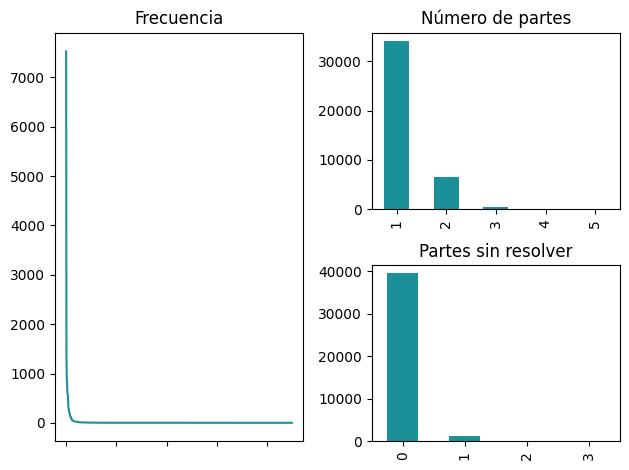

In [10]:
# Create a figure and a custom grid specification
fig = plt.figure()
gs = fig.add_gridspec(2, 2)
# Create subplots
ax1 = fig.add_subplot(gs[:, 0]) # All rows, first column
ax1 = df_cat['freq'].plot(ax=ax1, title='Frecuencia', xlabel='', color='#1c9099')
ax1.set_xticklabels([])
ax2 = fig.add_subplot(gs[0, 1]) # First row, second column
ax2 = df_cat.groupby('Npartes')['freq'].sum() \
            .plot.bar(ax=ax2, title='Número de partes', xlabel='', color='#1c9099')
ax3 = fig.add_subplot(gs[1, 1]) # Second row, second column
ax3 = df_cat.groupby('Nfalta')['freq'].sum() \
            .plot.bar(ax=ax3, title='Partes sin resolver', xlabel='', color='#1c9099')
# Adjust layout and plot
plt.tight_layout()
plt.show()

Estadísticas

Se observa cola derecha larga, probablemente ley de potencias

In [11]:
from scipy.stats import kurtosis

data = df_cat['freq'].describe()
data['kurtosis'] = kurtosis(df_cat['freq'], fisher=True)
data

count       2243.000000
mean          18.253678
std          219.285791
min            1.000000
25%            1.000000
50%            1.000000
75%            2.000000
max         7525.000000
kurtosis     859.568929
Name: freq, dtype: float64

Suma cumulativa

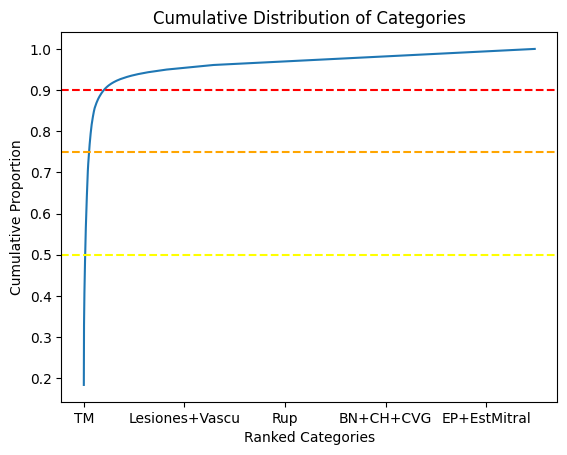

In [12]:
cum_prop = df_cat['freq'].cumsum() / df_cat['freq'].sum()
#display(cum_prop.head(15))
cum_prop.plot()
plt.axhline(0.9, color='red', linestyle='--')
plt.axhline(0.75, color='orange', linestyle='--')
plt.axhline(0.5, color='yellow', linestyle='--')
plt.title("Distribución cumulativa de categorias")
plt.ylabel("Proporción cumulatica")
plt.xlabel("Categorias por rango")
plt.savefig()
plt.show()

### Ajustar a ley de potencias

$$P(x)=\sigma\cdot x^{−α}$$

Calculating best minimal value for power law fit
alpha: 1.663s: 99%
sigma:0.038
xmin: 4.0
KS distance: 0.0501


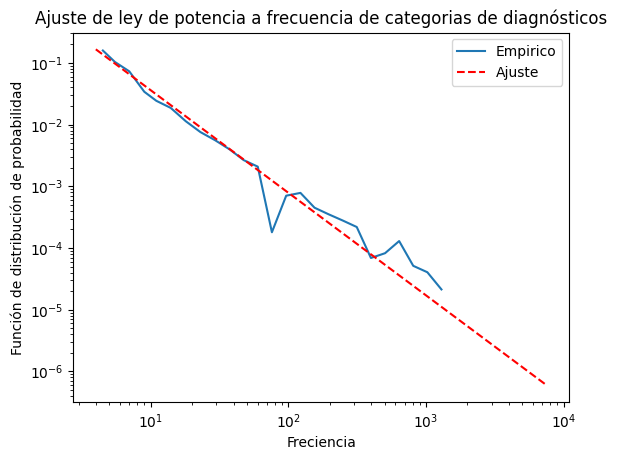

In [31]:
#! pip install powerlaw
import powerlaw

# Fit the model
fit = powerlaw.Fit(df_cat['freq'])

# Estimate alpha (exponent) and xmin
print(f"alpha: {fit.power_law.alpha:.3f}")
print(f"sigma:{fit.power_law.sigma:.3f}")
print(f"xmin: {fit.power_law.xmin}")
print(f"KS distance: {fit.power_law.D:.4f}")

# Plot the distribution and power-law fit
fit.plot_pdf(label='Empirico')
fit.power_law.plot_pdf(color='r', linestyle='--', label='Ajuste')
plt.legend()
plt.title(f"Ajuste de ley de potencia a frecuencia de categorias de diagnósticos")
plt.xlabel("Frecuencia")
plt.ylabel("Función de distribución de probabilidad")
#plt.savefig("imagenes/BO_Diagnostico_Distribucion.svg")
plt.show()


Comparando con otras distribuciones

In [14]:
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Likelihood ratio lognormal: {R}, p-value: {p}")
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Likelihood ratio exponential: {R}, p-value: {p}")

Likelihood ratio lognormal: -1.0612380892387543, p-value: 0.11658931265085201
Likelihood ratio exponential: 460.1506662030188, p-value: 6.519871792106589e-11


/home/esther/anaconda3/envs/SEMEFO_busqueda/lib/python3.12/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


### Red de diagnósticos sencillos

Determinar coocurrencia de diagnósticos

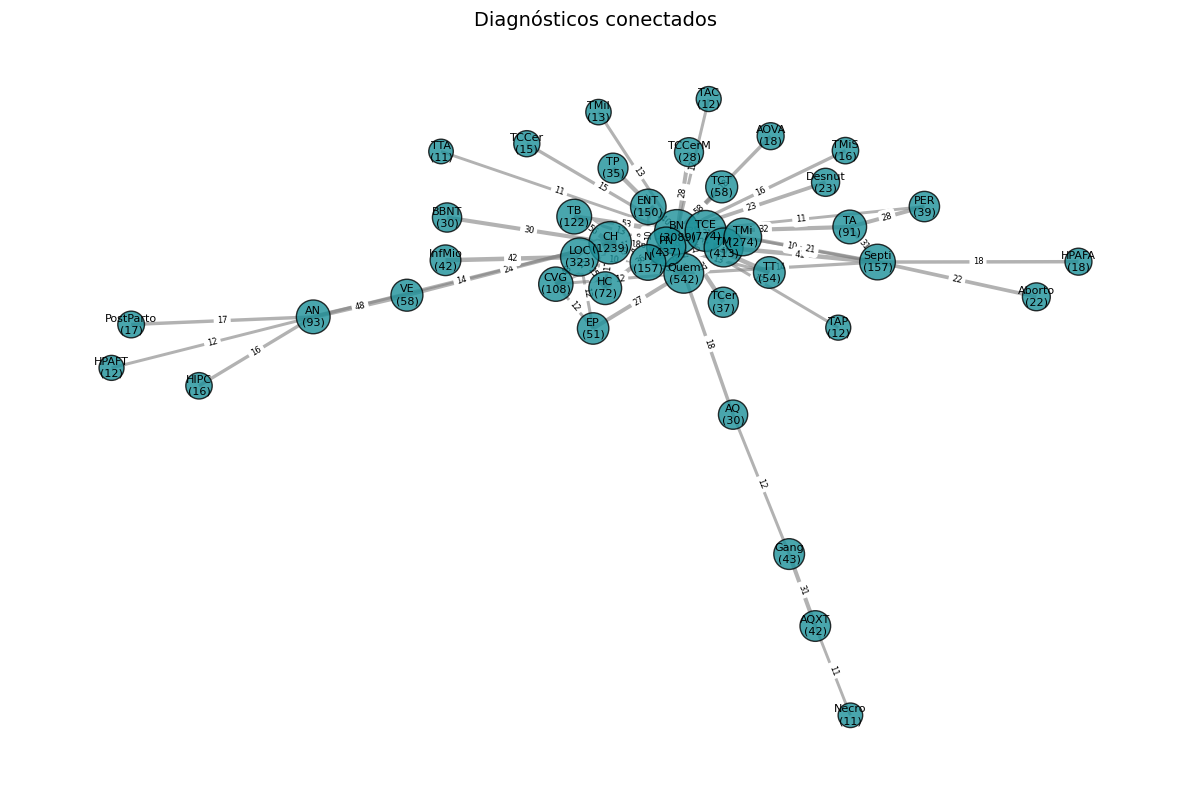

In [15]:
data = df_diag['Diagnostico_estandar'].value_counts()
data = data[data>=10]
data.to_list()
G = create_network_from_lists(data.index.to_list(), data.to_list(), sep='+') #, filter_singletons=False)

# Obtain log10 of weight
for node in G.nodes():
    G.nodes[node]["weight_log10"] = float(np.log10( G.nodes[node]["weight"] ))
    G.nodes[node]["weight_label"] = f"{node}\n({G.nodes[node]['weight']})"
for node1, node2 in G.edges():
    G.edges[node1, node2]["weight_log10"] = float(np.log10( G.edges[node1, node2]["weight"] ))
#print_graph_output(G)

# Plot the graph
plot_weighted_graph(
                    G, plot_title="Diagnósticos conectados", 
                    node_color='#1c9099', font_size=8,
                    node_size_attribute='weight_log10', edge_width_attribute='weight_log10',
                    node_label_attribute='weight', edge_label_attribute='weight',
                    )
print()
#export_graph_to_graphml(G, 'data_clean/HBO_diag_graph.graphml')

Conectividad de los diagnósticos sencillos

In [16]:
sorted(G.degree, key=lambda x: x[1], reverse=True)

[('BN', 25),
 ('CH', 11),
 ('PN', 8),
 ('LOC', 8),
 ('Quem', 7),
 ('N', 7),
 ('Septi', 7),
 ('TCE', 5),
 ('CVG', 5),
 ('AN', 5),
 ('TM', 4),
 ('TMi', 4),
 ('TB', 3),
 ('HC', 3),
 ('TA', 3),
 ('EP', 3),
 ('ENT', 2),
 ('TT', 2),
 ('VE', 2),
 ('AQXT', 2),
 ('Gang', 2),
 ('PER', 2),
 ('AQ', 2),
 ('TCT', 1),
 ('InfMio', 1),
 ('TCer', 1),
 ('TP', 1),
 ('BBNT', 1),
 ('TCCerM', 1),
 ('Desnut', 1),
 ('Aborto', 1),
 ('HPAFA', 1),
 ('AOVA', 1),
 ('PostParto', 1),
 ('TMiS', 1),
 ('HIPC', 1),
 ('TCCer', 1),
 ('TMiI', 1),
 ('TAP', 1),
 ('TAC', 1),
 ('HPAFT', 1),
 ('TTA', 1),
 ('Necro', 1)]

In [17]:
thr_freq = 5
data_thr_freq = df_cat['freq']>=thr_freq
data = df_cat.loc[(df_cat['Npartes']>1) & (data_thr_freq),'freq'].reset_index()
print(f"Diagnosticos compuestos con frecuencia >= {thr_freq}: {data.shape[0]}/{data_thr_freq.sum()}")
data.head(15)

Diagnosticos compuestos con frecuencia >= 5: 145/260


,Diagnostico_estandar,freq
0,BN+CH,800
1,BN+TCE,635
2,BN+Quem,414
3,BN+TM,297
4,BN+TMi,214
5,CH+PN,186
6,BN+ENT,140
7,BN+LOC,117
8,PN+TCE,88
9,PN+TM,60


## Diagnóstico por variable

### Diagnóstico vs tipo de restos

Tipo_restos,Cadáver conocido,Cadáver desconocido,Recién nacido,Feto,Miembros
Diagnostico_clasificacion,,,,,
Traumatismos,17199 (54.29%),2829 (47.8%),27 (13.43%),25 (2.34%),40 (4.32%)
Causas externas,3860 (12.19%),453 (7.65%),33 (16.42%),26 (2.44%),24 (2.59%)
Herida arma de fuego,3097 (9.78%),258 (4.36%),1 (0.5%),1 (0.09%),5 (0.54%)
Respiratorio,1513 (4.78%),824 (13.92%),32 (15.92%),12 (1.12%),1 (0.11%)
Digestivo,907 (2.86%),697 (11.78%),10 (4.98%),3 (0.28%),
"Sintomas, signos y hallazgos anormales",1231 (3.89%),203 (3.43%),2 (1.0%),2 (0.19%),
Afecciones periodo perinatal,14 (0.04%),41 (0.69%),81 (40.3%),974 (91.28%),
Sin datos,979 (3.09%),28 (0.47%),3 (1.49%),19 (1.78%),2 (0.22%)
Circulatorio,802 (2.53%),149 (2.52%),1 (0.5%),,4 (0.43%)


Text(0.5, 1.0, 'Ingresos por diagnóstico vs tipo restos')

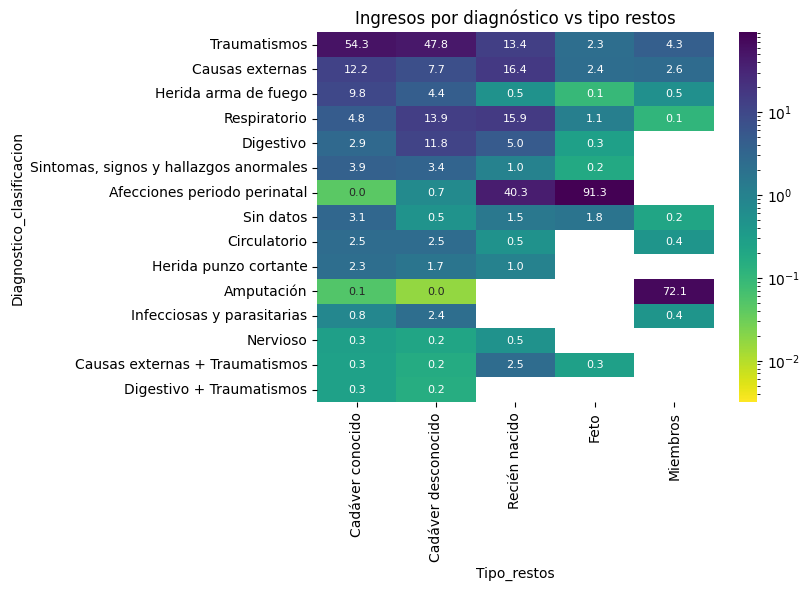

In [18]:
thr_show = 15
data = df_diag.pivot_table(index='Diagnostico_clasificacion', columns=['Tipo_restos'], values='Diagnostico_estandar', aggfunc='count')
data_per = (data/data.sum()*100).replace(0,nan)
data_annot = (data.astype(str) + " (" + data_per.round(2).astype(str) + "%)").replace('0 (nan%)','')
display( data_annot.head(thr_show) )
# Plot
log_norm = LogNorm(vmin=data_per.min().min(), vmax=data_per.max().max())
plt.figure()
sns.heatmap(data_per.head(thr_show), 
            annot=True, fmt=".1f", annot_kws={"size": 8}, 
            norm=log_norm, vmin=0, vmax=100, cmap='viridis_r')
#plt.savefig('imagenes/BO_Diagnostico_ClasificacionTipo.svg')
plt.title('Ingresos por diagnóstico vs tipo restos')

**Prueba de independencia $\chi^2$**

Supuestos:
* Variables Categóricas
* Observaciones Independientes
* Frecuencias Esperadas Suficientes: quitar `Recién nacido`, `Feto`, `Miembros`, tomar primeras 15
* Muestra Aleatoria Simple

Resultado:
**Muestra no independientes**: Chi-square: 2312.48
**Estadísticamente significativa**: P-value: 0.0

In [19]:
thr_show = 15
thr_resid = 10
data = df_diag.pivot_table(index='Diagnostico_clasificacion',columns='Tipo_restos', aggfunc='size')
data = data.drop(columns=['Recién nacido','Feto','Miembros']).head(thr_show)
data

# Perform Chi-square test
chi2, p_value, dof, expected = chi2_contingency(data)
print(f"Chi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

# visualize residuals
resid = (data.values - expected) / np.sqrt(expected)
resid = pd.DataFrame(resid, index=data.index, columns=data.columns)
resid.where(np.abs(resid) > thr_resid).dropna(how='all')

Chi-square statistic: 2312.4853816060518
Degrees of freedom: 14
P-value: 0.0


Tipo_restos,Cadáver conocido,Cadáver desconocido
Diagnostico_clasificacion,,
Herida arma de fuego,NaN,-11.717475
Respiratorio,-10.294630,23.847914
Digestivo,-12.103551,28.038350
Afecciones periodo perinatal,NaN,11.009909
Sin datos,NaN,-10.503770
Infecciosas y parasitarias,NaN,10.192982


### Diagnóstico vs sexo

Sexo,Femenino,Masculino
Diagnostico_clasificacion,,
Traumatismos,4419 (49.07%),15701 (51.0%)
Causas externas,1217 (13.51%),3179 (10.33%)
Herida arma de fuego,322 (3.58%),3040 (9.87%)
Respiratorio,632 (7.02%),1750 (5.68%)
Digestivo,255 (2.83%),1362 (4.42%)
"Sintomas, signos y hallazgos anormales",486 (5.4%),952 (3.09%)
Afecciones periodo perinatal,465 (5.16%),645 (2.1%)
Sin datos,299 (3.32%),732 (2.38%)
Circulatorio,203 (2.25%),753 (2.45%)


Text(0.5, 1.0, 'Ingresos por diagnóstico vs sexo')

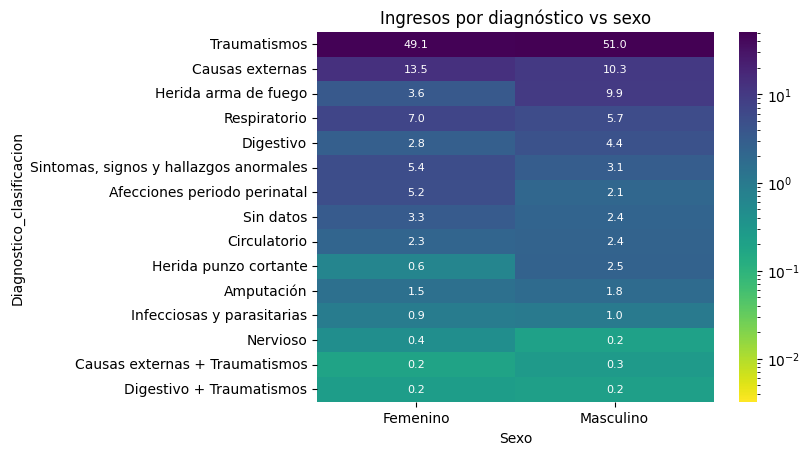

In [20]:
thr_show = 15
data = df_diag.pivot_table(index='Diagnostico_clasificacion', columns=['Sexo'], values='Diagnostico_estandar', aggfunc='count')
data_per = (data/data.sum()*100).replace(0,nan)
data_annot = (data.astype(str) + " (" + data_per.round(2).astype(str) + "%)").replace('0 (nan%)','')
display( data_annot.head(thr_show) )
# Plot
log_norm = LogNorm(vmin=data_per.min().min(), vmax=data_per.max().max())
plt.figure()
sns.heatmap(data_per.head(thr_show),
            annot=True, fmt=".1f", annot_kws={"size": 8}, 
            norm=log_norm, vmin=0, vmax=100, cmap='viridis_r')
#plt.savefig('imagenes/BO_Diagnostico_ClasificacionSexo.svg')
plt.title('Ingresos por diagnóstico vs sexo')

**Prueba de independencia $\chi^2$**

Supuestos:
* Variables Categóricas
* Observaciones Independientes
* Frecuencias Esperadas Suficientes: tomar primeras 20
* Muestra Aleatoria Simple

Resultado:
**Muestra no independientes**: Chi-square: 983.16
**Estadísticamente significativa**: P-value: 2.08e-196

In [21]:
thr_show = 20
thr_resid = 5
data = df_diag.pivot_table(index='Diagnostico_clasificacion',columns='Sexo', aggfunc='size')
data = data.head(thr_show)
data

# Perform Chi-square test
chi2, p_value, dof, expected = chi2_contingency(data)
print(f"Chi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

# visualize residuals
resid = (data.values - expected) / np.sqrt(expected)
resid = pd.DataFrame(resid, index=data.index, columns=data.columns)
resid.where(np.abs(resid) > thr_resid).dropna(how='all')

Chi-square statistic: 983.1646887853033
Degrees of freedom: 19
P-value: 2.0797691718354022e-196


Sexo,Femenino,Masculino
Diagnostico_clasificacion,,
Causas externas,7.436310,NaN
Herida arma de fuego,-15.690026,8.424586
Digestivo,-5.617565,NaN
"Sintomas, signos y hallazgos anormales",9.153117,NaN
Afecciones periodo perinatal,13.742875,-7.379085
Herida punzo cortante,-9.510575,5.106598


### Diagnóstico vs tipo de restos + sexo

Tipo_restos                            Cadáver conocido                  \
Sexo                                           Femenino       Masculino   
Diagnostico_clasificacion                                                 
Traumatismos                              4029 (53.47%)  13170 (54.55%)   
Causas externas                           1096 (14.55%)   2764 (11.45%)   
Herida arma de fuego                        300 (3.98%)   2797 (11.59%)   
Respiratorio                                504 (6.69%)    1009 (4.18%)   
Digestivo                                   183 (2.43%)      724 (3.0%)   
Sintomas, signos y hallazgos anormales      455 (6.04%)     776 (3.21%)   
Afecciones periodo perinatal                  5 (0.07%)       9 (0.04%)   
Sin datos                                   281 (3.73%)     698 (2.89%)   
Circulatorio                                186 (2.47%)     616 (2.55%)   
Herida punzo cortante                        55 (0.73%)     680 (2.82%)   
Amputación                                    3 (0.04%)      13 (0.05%)   
Infecciosas y parasitarias                   72 (0.96%)     174 (0.72%)   
Nervioso                                     39 (0.52%)      52 (0.22%)   
Causas externas + Traumatismos               12 (0.16%)       72 (0.3%)   
Digestivo + Traumatismos                     21 (0.28%)      62 (0.26%)   

Tipo_restos                            Cadáver desconocido                \
Sexo                                              Femenino     Masculino   
Diagnostico_clasificacion                                                  
Traumatismos                                   357 (47.1%)  2472 (47.9%)   
Causas externas                                93 (12.27%)   360 (6.98%)   
Herida arma de fuego                             22 (2.9%)   236 (4.57%)   
Respiratorio                                  113 (14.91%)  711 (13.78%)   
Digestivo                                        69 (9.1%)  628 (12.17%)   
Sintomas, signos y hallazgos anormales          30 (3.96%)   173 (3.35%)   
Afecciones periodo perinatal                    16 (2.11%)    25 (0.48%)   
Sin datos                                        7 (0.92%)    21 (0.41%)   
Circulatorio                                    17 (2.24%)   132 (2.56%)   
Herida punzo cortante                            2 (0.26%)    97 (1.88%)   
Amputación                                                     1 (0.02%)   
Infecciosas y parasitarias                       7 (0.92%)   133 (2.58%)   
Nervioso                                         1 (0.13%)    12 (0.23%)   
Causas externas + Traumatismos                                10 (0.19%)   
Digestivo + Traumatismos                         1 (0.13%)     8 (0.16%)   

Tipo_restos                            Recién nacido               \
Sexo                                        Femenino    Masculino   
Diagnostico_clasificacion                                           
Traumatismos                             11 (12.22%)  16 (14.41%)   
Causas externas                          15 (16.67%)  18 (16.22%)   
Herida arma de fuego                                     1 (0.9%)   
Respiratorio                             11 (12.22%)  21 (18.92%)   
Digestivo                                  3 (3.33%)    7 (6.31%)   
Sintomas, signos y hallazgos anormales     1 (1.11%)     1 (0.9%)   
Afecciones periodo perinatal             44 (48.89%)  37 (33.33%)   
Sin datos                                  1 (1.11%)     2 (1.8%)   
Circulatorio                                             1 (0.9%)   
Herida punzo cortante                                    2 (1.8%)   
Amputación                                                          
Infecciosas y parasitarias                                          
Nervioso                                                 1 (0.9%)   
Causas externas + Traumatismos             3 (3.33%)     2 (1.8%)   
Digestivo + Traumatismos                                            

Tipo_restos                          

Text(0.5, 1.0, 'Ingresos por diagnóstico, tipo restos y sexo')

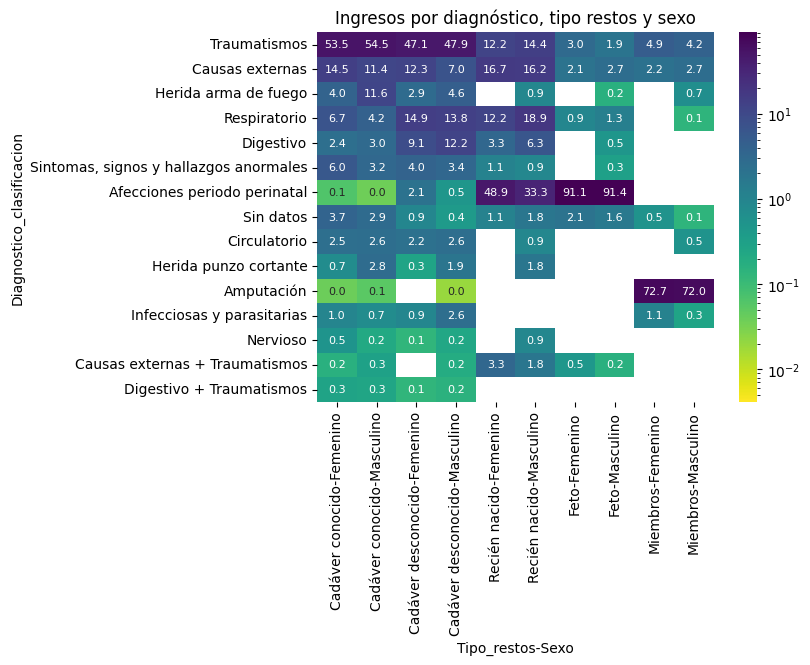

In [22]:
thr_show = 15
data = df_diag.pivot_table(index='Diagnostico_clasificacion', columns=['Tipo_restos','Sexo'], values='Diagnostico_estandar', aggfunc='count')
data_per = (data/data.sum()*100).replace(0,nan)
data_annot = (data.astype(str) + " (" + data_per.round(2).astype(str) + "%)").replace('0 (nan%)','')
display( data_annot.head(thr_show) )
# Plot
log_norm = LogNorm(vmin=data_per.min().min(), vmax=data_per.max().max())
plt.figure()
sns.heatmap(data_per.head(thr_show),
            annot=True, fmt=".1f", annot_kws={"size": 8}, 
            norm=log_norm, vmin=0, vmax=100, cmap='viridis_r')
plt.title('Ingresos por diagnóstico, tipo restos y sexo')

Revisando diagnósticos con discrepancia de género

In [23]:
col_tran = [c for c in df_diag.columns if 'transcrito' in c]
df_diag.loc[(df_diag['Diagnostico_clasificacion']=='Embarazo, parto y puerperio')&(df_diag['Sexo']=='Masculino'), col_tran]

,Numero_progresivo_transcrito,Nombre_completo_transcrito,Fecha_transcrito,Edad_transcrito,Diagnostico_transcrito,Procedencia_transcrito,Numero_acta_transcrito,Expediente_SEMEFO_transcrito,Foja_transcrito
ID,,,,,,,,,
BO_1977_02967,63,mendoza hernandez anselmo,1977-02-03,39,RPlacenta,IZA-II,201,697,69 reverso


Principales diagnósticos por tipo y sexo

In [24]:
top_ = lambda s: top_values_of_series_to_string(s,thr_min=10)
data = df_diag.pivot_table(
    index='Diagnostico_clasificacion',
    columns=['Tipo_restos','Sexo'],
    values='Diagnostico_estandar',
    aggfunc=top_,
    
)
top_diag = df_diag['Diagnostico_clasificacion'].value_counts()
data = pd.concat([top_diag,data,], axis=1).sort_values('count', ascending=False)
data.head(thr_show)

,count,"(Cadáver conocido, Femenino)","(Cadáver conocido, Masculino)","(Cadáver desconocido, Femenino)","(Cadáver desconocido, Masculino)","(Recién nacido, Femenino)","(Recién nacido, Masculino)","(Feto, Femenino)","(Feto, Masculino)","(Miembros, Femenino)","(Miembros, Masculino)"
Diagnostico_clasificacion,,,,,,,,,,,
Traumatismos,20120,"TM (1542), TCE (1098), TCT (248), BN+TMi (98),...","TM (4545), TCE (4090), TCT (781), BN+TCE (495)...","TM (202), TCE (81), TCT (15)","TM (1224), TCE (693), TCT (141), BN+TCE (47), ...",NaN,NaN,NaN,NaN,NaN,TMi (26)
Causas externas,4396,"Quem (257), HC (185), AOVA (165), BN+Quem (140...","AOVA (513), Quem (477), AXA (448), ASB (354), ...","Quem (19), AOVA (17), AE (16), ASB (11), HC (11)","AOVA (107), ASB (69), Quem (57), AXA (33), HC ...",NaN,AE (10),NaN,NaN,NaN,NaN
Herida arma de fuego,3362,"HPAFC (116), HPAF (69), HPAFPT (48), HPAFA (31...","HPAF (845), HPAFC (752), HPAFPT (504), HPAFA (...",HPAF (11),"HPAF (72), HPAFC (68), HPAFPT (48), HPAFA (14)...",NaN,NaN,NaN,NaN,NaN,NaN
Respiratorio,2382,"BN (400), PN (32), N (28), EP (14), BBNT (11)","BN (747), PN (105), N (70), EP (29), InfPul (22)",BN (98),"BN (576), PN (90), N (26), BBNT (11)",BN (10),BN (19),NaN,NaN,NaN,NaN
Digestivo,1617,"BN+CH (54), BN+ENT (34), CH (22), CH+PN (12), ...","BN+CH (320), CH+PN (84), CH (71), BN+ENT (59),...","BN+CH (39), BN+ENT (17)","BN+CH (386), CH+PN (86), CH (62), BN+ENT (22),...",NaN,NaN,NaN,NaN,NaN,NaN
"Sintomas, signos y hallazgos anormales",1438,"CVG (412), BN+CVG (10)",CVG (724),CVG (28),CVG (163),NaN,NaN,NaN,NaN,NaN,NaN
Afecciones periodo perinatal,1110,NaN,NaN,NaN,ANEN (16),ANEN (40),ANEN (35),"ANEN (196), EXPSM (186), FCPN (11)","EXPSM (304), ANEN (257)",NaN,NaN
Sin datos,1054,Dispensa (265),"Dispensa (653), NoCopia (30), nan (14), Indet ...",NaN,Indet (15),NaN,NaN,NaN,NaN,NaN,NaN
Circulatorio,956,"LOC (123), BN+LOC (18), InfMio+LOC (14)","LOC (444), BN+LOC (75), InfMio+LOC (22), LOC+P...",LOC (11),"LOC (93), BN+LOC (21)",NaN,NaN,NaN,NaN,NaN,NaN


### Diagnóstico vs grupo de edad

Edad_grupo,"[0, 1)","[1, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 110)"
Diagnostico_clasificacion,,,,,,,,,,,,,,,,,,,
Traumatismos,236 (9.93%),871 (46.4%),1019 (74.33%),817 (67.46%),1223 (51.26%),1877 (50.5%),2036 (54.6%),1542 (51.87%),1661 (53.39%),1372 (51.06%),1378 (52.56%),1257 (54.49%),916 (52.83%),1007 (55.45%),882 (55.75%),821 (54.19%),594 (60.06%),304 (59.03%),263 (61.74%)
Causas externas,359 (15.1%),667 (35.54%),173 (12.62%),185 (15.28%),321 (13.45%),401 (10.79%),342 (9.17%),315 (10.6%),290 (9.32%),244 (9.08%),227 (8.66%),198 (8.58%),151 (8.71%),122 (6.72%),119 (7.52%),105 (6.93%),87 (8.8%),24 (4.66%),41 (9.62%)
Herida arma de fuego,9 (0.38%),22 (1.17%),37 (2.7%),59 (4.87%),366 (15.34%),712 (19.16%),643 (17.24%),431 (14.5%),328 (10.54%),213 (7.93%),184 (7.02%),94 (4.07%),82 (4.73%),50 (2.75%),52 (3.29%),43 (2.84%),18 (1.82%),9 (1.75%),4 (0.94%)
Respiratorio,364 (15.31%),94 (5.01%),18 (1.31%),29 (2.39%),37 (1.55%),64 (1.72%),87 (2.33%),123 (4.14%),169 (5.43%),220 (8.19%),213 (8.12%),189 (8.19%),130 (7.5%),171 (9.42%),127 (8.03%),151 (9.97%),84 (8.49%),68 (13.2%),40 (9.39%)
Digestivo,155 (6.52%),32 (1.7%),10 (0.73%),2 (0.17%),13 (0.54%),28 (0.75%),55 (1.47%),115 (3.87%),205 (6.59%),225 (8.37%),191 (7.28%),164 (7.11%),114 (6.57%),108 (5.95%),73 (4.61%),73 (4.82%),27 (2.73%),19 (3.69%),8 (1.88%)
"Sintomas, signos y hallazgos anormales",54 (2.27%),92 (4.9%),29 (2.12%),35 (2.89%),131 (5.49%),166 (4.47%),147 (3.94%),122 (4.1%),129 (4.15%),111 (4.13%),103 (3.93%),80 (3.47%),66 (3.81%),60 (3.3%),43 (2.72%),45 (2.97%),16 (1.62%),2 (0.39%),5 (1.17%)
Afecciones periodo perinatal,1081 (45.48%),,16 (1.17%),1 (0.08%),1 (0.04%),,,,,,1 (0.04%),,,,,7 (0.46%),,,
Sin datos,41 (1.72%),46 (2.45%),28 (2.04%),21 (1.73%),67 (2.81%),80 (2.15%),72 (1.93%),50 (1.68%),27 (0.87%),36 (1.34%),43 (1.64%),44 (1.91%),54 (3.11%),56 (3.08%),53 (3.35%),55 (3.63%),37 (3.74%),21 (4.08%),19 (4.46%)
Circulatorio,6 (0.25%),3 (0.16%),1 (0.07%),7 (0.58%),10 (0.42%),15 (0.4%),23 (0.62%),29 (0.98%),44 (1.41%),53 (1.97%),80 (3.05%),109 (4.72%),95 (5.48%),112 (6.17%),118 (7.46%),117 (7.72%),73 (7.38%),37 (7.18%),20 (4.69%)


Text(0.5, 1.0, 'Ingresos por diagnóstico vs sexo')

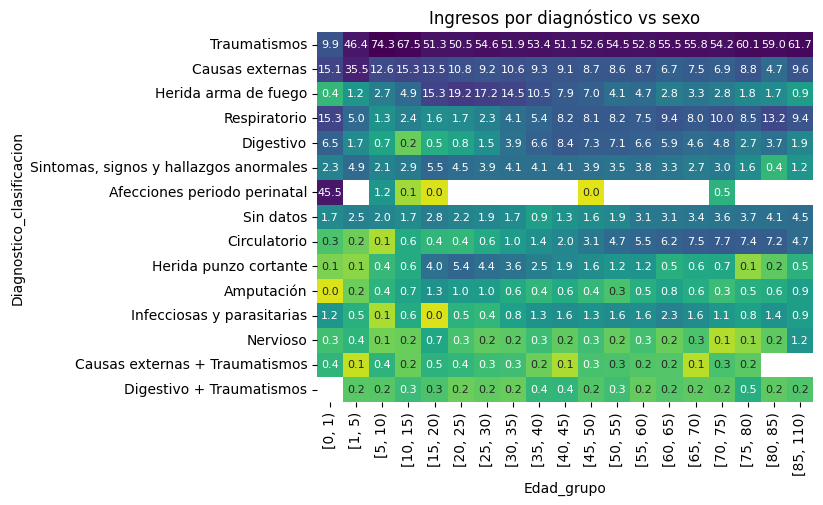

In [25]:
thr_show = 15
data = df_diag.pivot_table(index='Diagnostico_clasificacion', columns=['Edad_grupo'], values='Diagnostico_estandar', aggfunc='count')
data_per = (data/data.sum()*100).replace(0,nan)
data_annot = (data.astype(str) + " (" + data_per.round(2).astype(str) + "%)").replace('0 (nan%)','')
display( data_annot.head(thr_show) )
# Plot
log_norm = LogNorm(vmin=data_per.min().min(), vmax=data_per.max().max())
plt.figure()
sns.heatmap(data_per.head(thr_show),
            annot=True, fmt=".1f", annot_kws={"size": 8}, 
            norm=log_norm, vmin=0, vmax=100, cmap='viridis_r', cbar=False)
#plt.savefig('imagenes/BO_Diagnostico_ClasificacionEdad.svg')
plt.title('Ingresos por diagnóstico vs sexo')

Principales diagnósticos por clasificación

In [26]:
top_ = lambda s: top_values_of_series_to_string(s,thr_min=10)
data = df_diag.pivot_table(
    index='Diagnostico_clasificacion',
    columns='Edad_grupo',
    values='Diagnostico_estandar',
    aggfunc=top_,
    
)
top_diag = df_diag['Diagnostico_clasificacion'].value_counts()
data = pd.concat([top_diag,data,], axis=1).sort_values('count', ascending=False)
data.head(thr_show)

,count,"[0, 1)","[1, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 110)"
Diagnostico_clasificacion,,,,,,,,,,,,,,,,,,,,
Traumatismos,20120,"TCE (154), TM (28), BN+TCE (10)","TCE (320), TM (276), TCT (52), TTA (34), TAC (31)","TM (370), TCE (342), TCT (61), TAC (32), TTA (30)","TM (323), TCE (256), TCT (46), TAC (25), TTA (23)","TCE (429), TM (424), TCT (69), BN+TCE (25), TT...","TM (706), TCE (591), TCT (92), BN+TCE (57), TT...","TM (842), TCE (603), TCT (88), TTA (63), BN+TC...","TM (630), TCE (436), TCT (85), TTA (45), BN+TC...","TM (672), TCE (459), TCT (92), BN+TCE (49), TT...","TM (556), TCE (406), TCT (77), BN+TCE (43), TT...","TM (527), TCE (425), TCT (86), BN+TCE (41), TT...","TM (463), TCE (361), TCT (80), BN+TCE (51), TT...","TM (344), TCE (270), TCT (77), BN+TCE (29), TT...","TM (384), TCE (267), TCT (66), BN+TM (29), BN+...","TM (317), TCE (211), TCT (60), BN+TCE (40), TT...","TM (292), TCE (200), TCT (65), BN+TCE (48), BN...","TM (204), TCE (124), TCT (39), BN+TCE (30), BN...","TM (89), TCE (72), TCT (26), BN+TMi (24), BN+T...","TM (68), TCE (57), BN+TMi (25), TCT (16), BN+T..."
Causas externas,4396,"AOVA (152), Quem (66), AE (24), BN+Quem (23), ...","Quem (211), ASB (156), BN+Quem (155), AOVA (67...","Quem (47), ASB (33), BN+Quem (29), AOVA (25)","ASB (46), AXA (30), Quem (27), AOVA (22), BN+Q...","AXA (67), ASB (58), AOVA (47), Quem (40), Elec...","AXA (120), ASB (62), Quem (57), AOVA (34), BN+...","AXA (87), Quem (78), ASB (39), AOVA (37), Elec...","Quem (56), AXA (54), AOVA (49), HC (30), ASB (28)","AOVA (65), AXA (41), Quem (37), ASB (34), HC (32)","AOVA (55), AXA (40), Quem (37), HC (33), BN+Qu...","AOVA (70), HC (40), Quem (30), AXA (20), ASB (12)","AOVA (57), HC (41), AXA (28), Quem (12), ASB (11)","AOVA (42), HC (32), Quem (21), AXA (19)","AOVA (32), HC (31), Quem (21), AXA (10)","HC (36), AOVA (22), Quem (19), AXA (13)","HC (36), Quem (21), AOVA (12)","HC (26), Quem (20), AOVA (13)",NaN,HC (13)
Herida arma de fuego,3362,NaN,HPAFC (12),HPAFC (19),"HPAFC (25), HPAF (14), HPAFPT (14)","HPAFC (100), HPAF (98), HPAFPT (84), HPAFA (34...","HPAF (227), HPAFC (173), HPAFPT (142), HPAFA (...","HPAF (204), HPAFC (166), HPAFPT (114), HPAFA (...","HPAFC (129), HPAF (128), HPAFPT (62), HPAFTA (...","HPAF (106), HPAFC (79), HPAFPT (58), HPAFTA (3...","HPAF (62), HPAFC (57), HPAFPT (37), HPAFA (23)...","HPAFC (52), HPAF (41), HPAFPT (33), HPAFA (29)...","HPAF (34), HPAFC (32), HPAFPT (11)","HPAFC (26), HPAF (25), HPAFPT (10)","HPAF (15), HPAFC (14), HPAFPT (10)","HPAFC (21), HPAF (16)",HPAFC (23),NaN,NaN,NaN
Respiratorio,2382,"BN (333), N (13)",BN (80),BN (15),BN (19),BN (21),BN (44),BN (60),"BN (96), PN (17)","BN (123), PN (28)","BN (158), PN (31), N (18)","BN (175), PN (14), N (13)","BN (148), PN (22), N (11)","BN (90), PN (16)","BN (122), PN (24), N (11)","BN (94), PN (18)","BN (119), PN (16)",BN (66),BN (54),BN (34)
Digestivo,1617,"BN+ENT (114), ENT (15)",BN+ENT (16),NaN,NaN,NaN,BN+CH (14),BN+CH (18),"BN+CH (55), CH (18), CH+PN (16), Pancrea (10)","BN+CH (105), CH+PN (28), CH (25), CH+N (12)","BN+CH (127), CH+PN (31), CH (31)","BN+CH (112), CH+PN (31), CH (21)","BN+CH (103), CH (22), CH+PN (12)","BN+CH (70), CH+PN (17), CH (11)","BN+CH (78), CH+PN (14)","BN+CH (39), CH+PN (10)","BN+CH (42), CH+PN (13)",BN+CH (12),NaN,NaN
"Sintomas, signos y hallazgos anormales",1438,CVG (49),CVG (86),CVG (26),CVG (32),CVG (128),CVG (152),CVG (135),CVG (111),CVG (120),CVG (102),CVG (97),CVG (76),CVG (62),CVG (53),CVG (39),CVG (38),CVG (15),NaN,NaN
Afecciones periodo perinatal,1110,"ANEN (546), EXPSM (493), FCPN (25)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sin datos,1054,"Indet (27), Dispensa (13)",Dispensa (45),Dispensa (25),Dispensa (20),Dispensa (62),Dispensa (70),Dispensa (59),Dispensa (44),Dispensa (21),Dispensa (31),Dispensa (35),Dispensa (40),Dispensa (52),Di

**Prueba de independencia $\chi^2$**

Supuestos:
* Variables Categóricas
* Observaciones Independientes
* Frecuencias Esperadas Suficientes: tomar primeras 12
* Muestra Aleatoria Simple

Resultado:
**Muestra no independientes**: Chi-square: 23658.15
**Estadísticamente significativa**: P-value: 0.0

In [27]:
thr_show = 15
thr_resid = 10
data = df_diag.pivot_table(index='Diagnostico_clasificacion',columns='Edad_grupo', aggfunc='size')
data = data.head(thr_show)
data

# Perform Chi-square test
chi2, p_value, dof, expected = chi2_contingency(data)
print(f"Chi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

# visualize residuals
resid = (data.values - expected) / np.sqrt(expected)
resid = pd.DataFrame(resid, index=data.index, columns=data.columns)
resid.where(np.abs(resid) > thr_resid).dropna(how='all').dropna(how='all', axis=1)

Chi-square statistic: 23749.714438438372
Degrees of freedom: 252
P-value: 0.0


Edad_grupo,"[0, 1)","[1, 5)","[5, 10)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[40, 45)","[60, 65)","[65, 70)","[70, 75)"
Diagnostico_clasificacion,,,,,,,,,,,
Traumatismos,-28.628766,NaN,11.257885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Causas externas,NaN,31.004288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Herida arma de fuego,-13.814234,-11.092774,NaN,11.116784,21.812760,17.829190,10.887694,NaN,NaN,NaN,NaN
Respiratorio,17.797810,NaN,NaN,NaN,-10.841618,NaN,NaN,NaN,NaN,NaN,NaN
Digestivo,NaN,NaN,NaN,NaN,-10.187742,NaN,NaN,10.81898,NaN,NaN,NaN
Afecciones periodo perinatal,122.075029,NaN,NaN,NaN,-10.291915,-10.317415,NaN,NaN,NaN,NaN,NaN
Circulatorio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.173995,12.91482,13.287054
Herida punzo cortante,NaN,NaN,NaN,NaN,13.343370,NaN,NaN,NaN,NaN,NaN,NaN


## Red palabras por clasificación

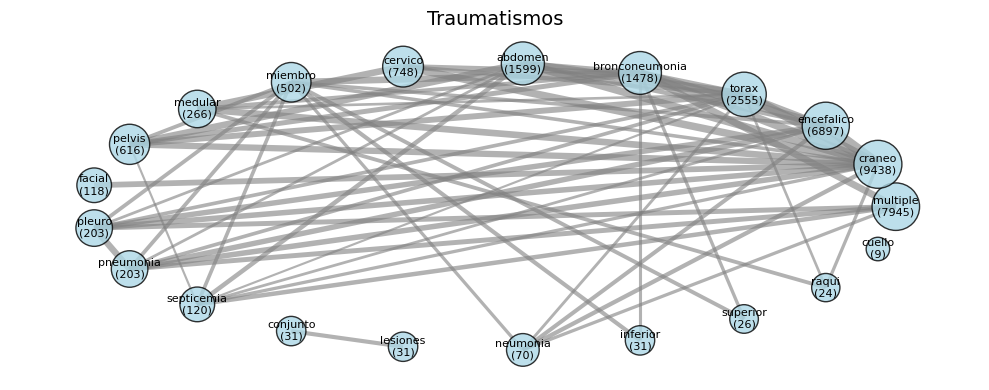

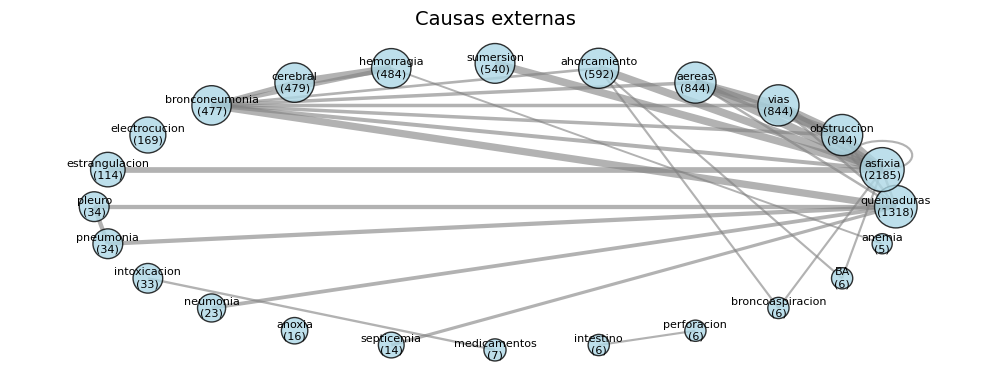

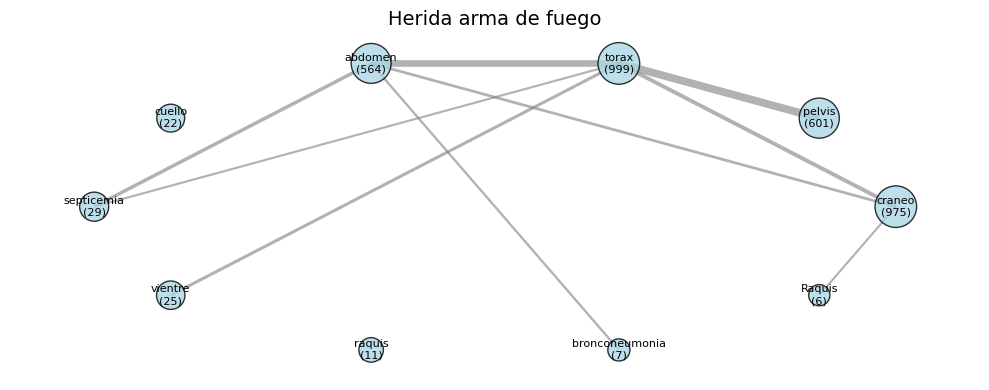

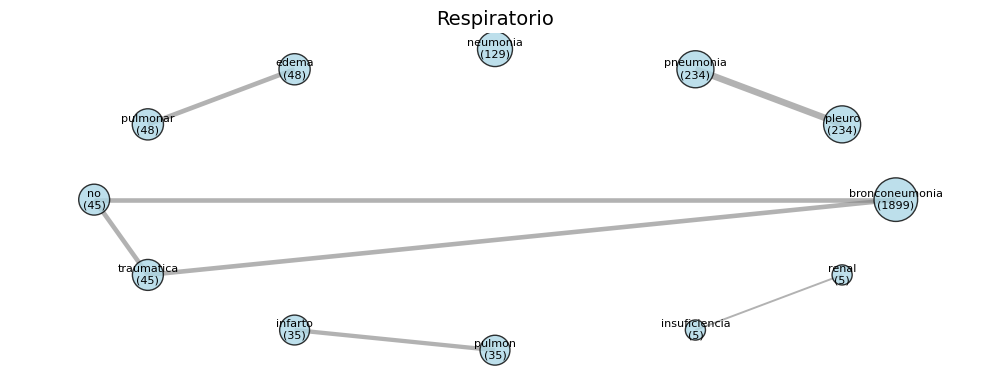

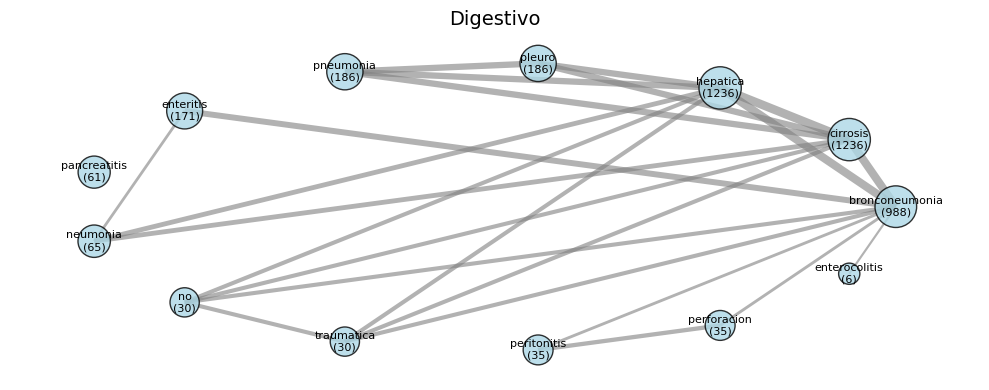

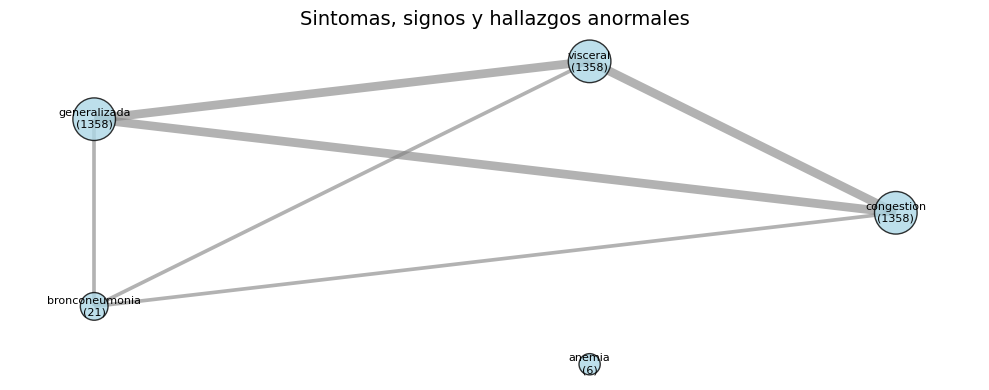

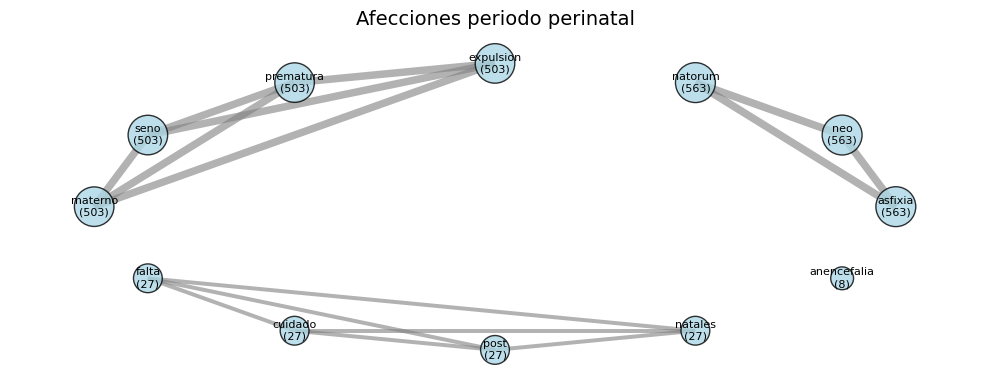

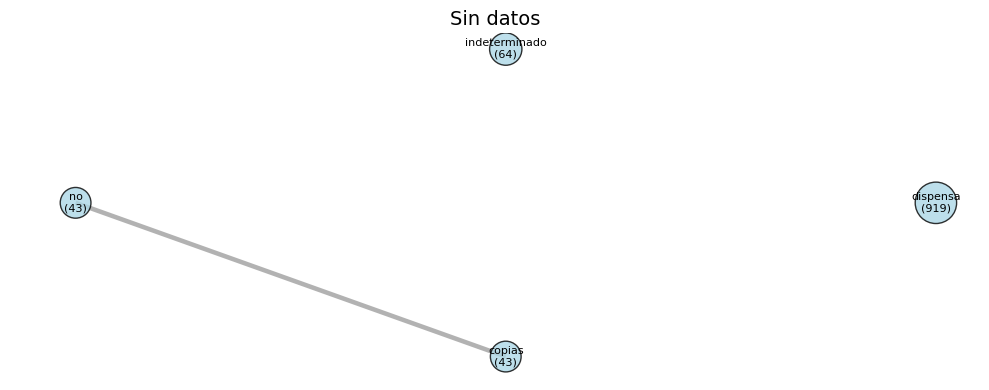

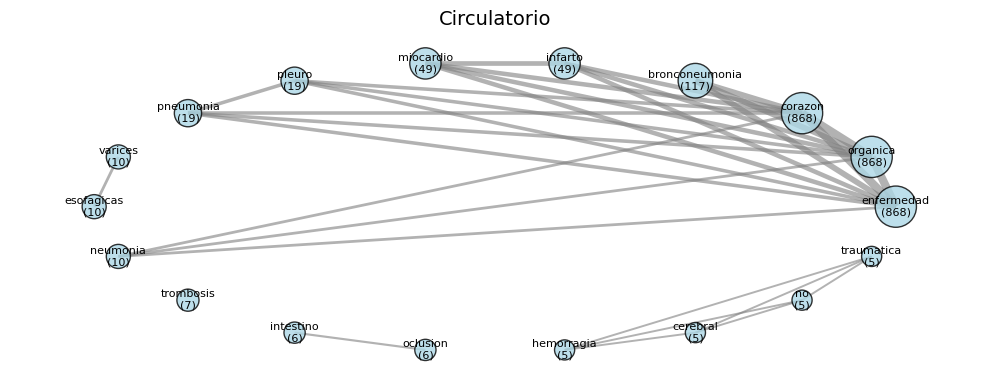

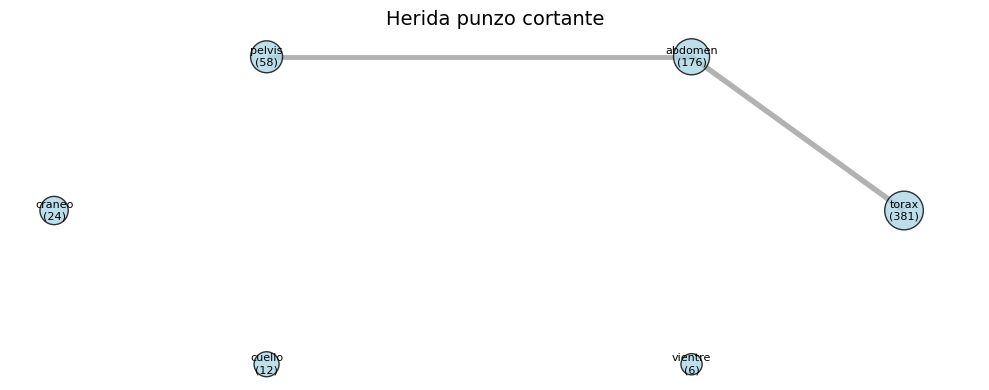

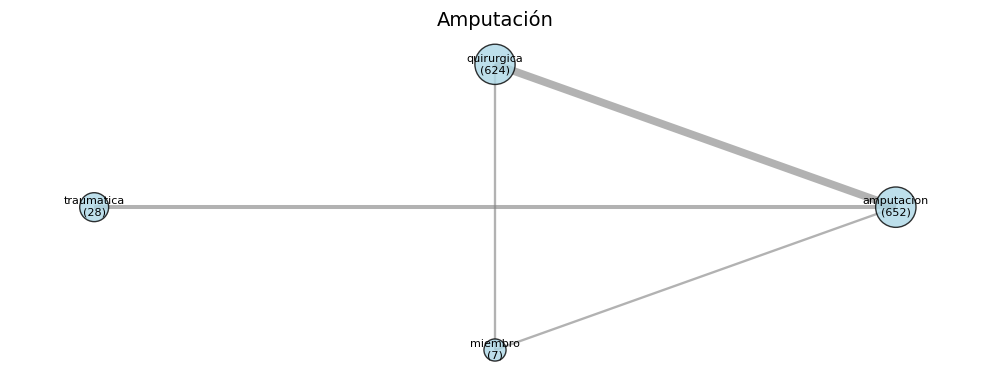

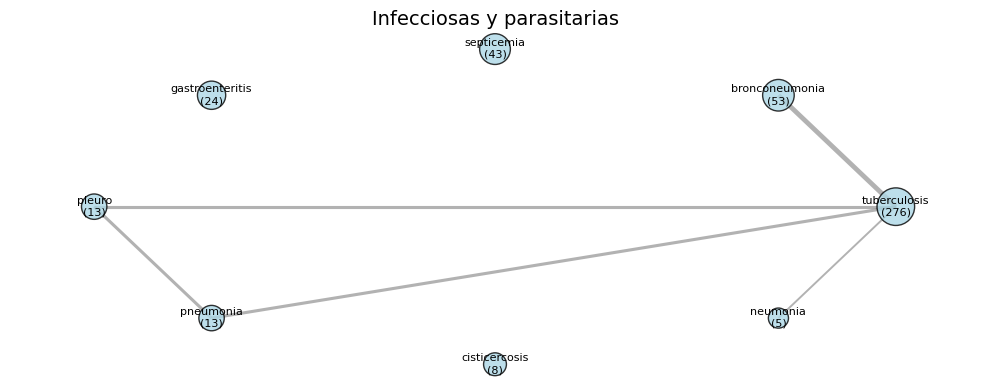

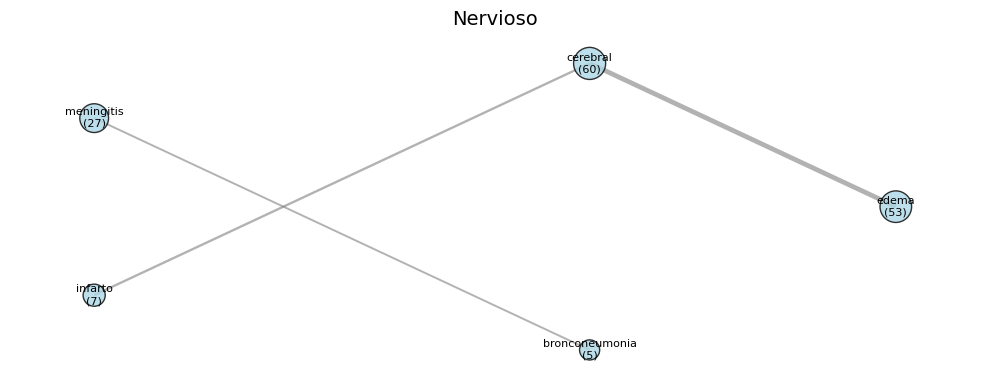

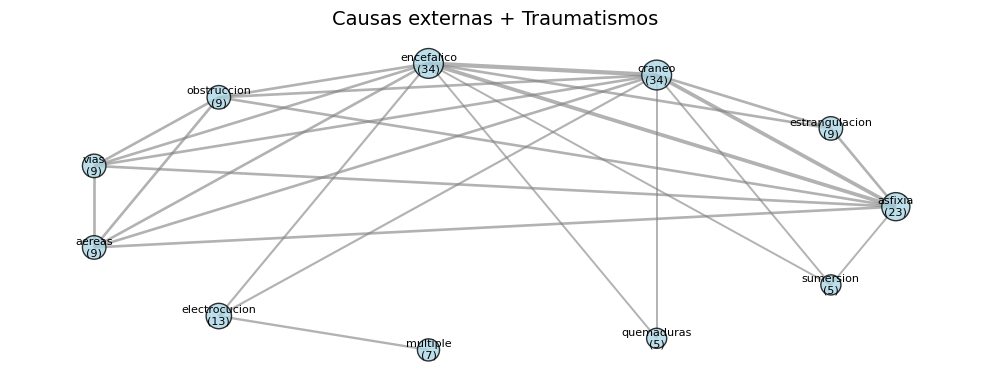

In [29]:
thr = 5
filtered = ['+','o','traumatismo','herida','arma','fuego','punzo','cortante','de','del','por',]

classes =  df_diag['Diagnostico_clasificacion'].value_counts().head(14).index.values
for clas in classes:
    data = df_diag.loc[df_diag['Diagnostico_clasificacion']==clas,'Diagnostico_extendido'].value_counts()
    data = data[data>=thr]
    G = create_network_from_lists(data.index.to_list(), data.to_list(), remove_list=filtered, filter_singletons=False, sep=' ')
    
    # Obtain log10 of weight
    for node in G.nodes():
        G.nodes[node]["weight_log10"] = float(np.log10( G.nodes[node]["weight"] ))
    for node1, node2 in G.edges():
        G.edges[node1, node2]["weight_log10"] = float(np.log10( G.edges[node1, node2]["weight"] ))
    
    # Plot the graph
    plot_weighted_graph(
                        G, plot_title=clas, 
                        figsize=(10,4), font_size=8, layout='circular',
                        node_size_attribute='weight_log10', edge_width_attribute='weight_log10',
                        node_label_attribute='weight')
    #print(sorted(G.degree, key=lambda x: x[1], reverse=True))[0:5]
    #export_graph_to_graphml(G, f"data_clean/red_palabras/HBO_diag_{clas.replace(' ','')}_graph.graphml")

**Done**